# Analysis of JMorgan & Chase Co [JPM] using Regression Testing and Naive Bayes Algorithm 

Support Vector Machine (SVM), is utilized for supervised leaning models with associated algorithms that analyze data used for classification and regression analysis. The following Libaries and Packages will be listed below:

- Yfinance: an API Used to pull data from Yahoo Finance servers
- Numpy: Used for arrays, and matrices.
- Matplotlib: an extension from Numpy, Used for plotting and graphing of the given Dataset.
- Seaborn: Library used for statistical visualization based on Matplotlib.
- Talib: Technical Analysis Indicators, used to help stock traders make investment decisions.
- Sklearn: Machine Learning Package used for classification/clustering, and regression algorithms.

The Dataset Used Would be based on a historical stock data from 1990-05-15-2020-05-15.

First, I imported the packages needed to perform the supervised learning model. Furthermore, I utilize the Yahoo Finance API to pull historical data. For this SVM analysis, I will be working on JPM. 

In [14]:
#Importing Packages
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
from sklearn import mixture as mix
import seaborn as sns
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import yfinance as yf

In [15]:
#Getting Historical Stock Data From Yahoo Finance Using API
JPM = pdr.get_data_yahoo('JPM', '1990-05-15','2020-05-15')
JPM = JPM.dropna()
JPM = JPM.iloc[:,:4]
JPM.head()

,High,Low,Open,Close
Date,,,,
1990-05-15,9.041667,8.666667,8.708333,8.958333
1990-05-16,8.916667,8.666667,8.875000,8.833333
1990-05-17,8.958333,8.750000,8.916667,8.833333
1990-05-18,9.000000,8.916667,8.958333,8.916667
1990-05-21,9.041667,8.791667,8.833333,8.958333


The Dataset needs to be split into training and testing. I will be splitting 70% for training and remaining 20% for testing. Its parameters can be changed as you please. Its data will be using by looking back the previous 90 days.

In [16]:
n = 90
t = 0.7
split = int(t*len(JPM))

The High, Close, Low have been all shifted at 1, in order to access its historical data. After that I went ahead to coded its Technical Indicators, such as RSI, SMA, ADX, SAR, and Return of the past 1 day on a Open-Open basis. Next, its dataframe is outputted below.

In [17]:
JPM['High']=JPM['High'].shift(1)
JPM['Low']=JPM['Low'].shift(1)
JPM['Close']=JPM['Close'].shift(1)
JPM['RSI']=ta.RSI(np.array(JPM['Close']), timeperiod=n)
JPM['SMA']=JPM['Close'].rolling(window=n).mean()
JPM['Corr']=JPM['SMA'].rolling(window=n).corr(JPM['Close'])
JPM['SAR']=ta.SAR(np.array(JPM['High']),np.array(JPM['Low']),\
                  0.2,0.2)
JPM['ADX']=ta.ADX(np.array(JPM['High']),np.array(JPM['Low']),\
                  np.array(JPM['Close']), timeperiod=n)
JPM['Return']=np.log(JPM['Open']/JPM['Open'].shift(1))
    

In [18]:
print(JPM.head())

                High       Low      Open     Close  RSI  SMA  Corr       SAR  \
Date                                                                           
1990-05-15       NaN       NaN  8.708333       NaN  NaN  NaN   NaN       NaN   
1990-05-16  9.041667  8.666667  8.875000  8.958333  NaN  NaN   NaN       NaN   
1990-05-17  8.916667  8.666667  8.916667  8.833333  NaN  NaN   NaN  8.916667   
1990-05-18  8.958333  8.750000  8.958333  8.833333  NaN  NaN   NaN  8.666667   
1990-05-21  9.000000  8.916667  8.833333  8.916667  NaN  NaN   NaN  8.666667   

            ADX    Return  
Date                       
1990-05-15  NaN       NaN  
1990-05-16  NaN  0.018958  
1990-05-17  NaN  0.004684  
1990-05-18  NaN  0.004662  
1990-05-21  NaN -0.014052  


I have coded to drop all of the 'NaN' values. So in order to get the machine to learn the dataset, those 'NaN' values need to be dropped to get an optimal result. Its algorithm is below.

In [19]:
JPM=JPM.dropna()

Below is where the real work starts, I have coded the Unsupervised Learning Algorithm to make the regime prediction. I have added splits for the dataset, variables have been defined.

The scatter graph being outputted shows the Co-variances for Regimes 0-3. The Co-Variances in terms of finance is defined by two variables which tells us how likely would the stock market increase or vice-versa. A positive Co-Variance usually means that the price of one stock would go up as well as the other would too, whereas a negative Co-Variance, the price of one stock goes down, the other stock would follow that pattern. 

C:\Users\kelba\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


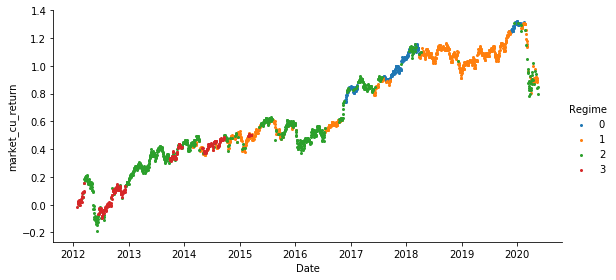

Mean for regime 0:  1.03587227368567
Co_Variance for regime 0:  0.23659791134699615
Mean for regime 1:  -0.4535461853490202
Co_Variance for regime 1:  0.45362302457153186
Mean for regime 2:  0.2363771079542735
Co_Variance for regime 2:  1.207786776468411
Mean for regime 3:  -0.24768305196295642
Co_Variance for regime 3:  0.20040326418392831


In [20]:
ss = StandardScaler()
unsup = mix.GaussianMixture(n_components=4,
                           covariance_type = "spherical",
                           n_init = 100,
                           random_state = 42)
JPM = JPM.drop(['Open','High','Low','Close'], axis = 1)
unsup.fit(np.reshape(ss.fit_transform(JPM[:split]),(-1,JPM.shape[1])))
regime = unsup.predict(np.reshape(ss.fit_transform(JPM[split:]),\
                                                        (-1,JPM.shape[1])))
Regimes = pd.DataFrame(regime,columns=['Regime'],index=JPM[split:].index)\
.join(JPM[split:],how='inner')\
.assign(market_cu_return=JPM[split:]\
       .Return.cumsum())\
.reset_index(drop=False)\
.rename(columns={'index':'Date'})

order=[0,1,2,3]
fig = sns.FacetGrid(data=Regimes,hue='Regime',hue_order=order,aspect=2,size=4)
fig.map(plt.scatter,'Date','market_cu_return',s=4).add_legend()
plt.show()

for i in order:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co_Variance for regime %i: '%i,(unsup.covariances_[i]))


Furthermore, The Dataframe and its Regimes are scaled, excluding the Date and Regimes columns, By this method, There would not be any loss of features, However, the data will be scaled and ready for training the support vector classifier algorithm. 
Next, I created a signal column which would act as the prediction values. The algorithm would train on the features’ set to predict this signal.

In [21]:
ss1=StandardScaler()
columns=Regimes.columns.drop(['Regime','Date'])
Regimes[columns]=ss1.fit_transform(Regimes[columns])
Regimes['Signal']=0
Regimes.loc[Regimes['Return']>0,'Signal']=1
Regimes.loc[Regimes['Return']<0,'Signal']=-1

Next, I defined a function for the support vector classifier. 

In [22]:
cls = SVC(C=1.0,cache_size=200,class_weight=None,coef0=0.0,
          decision_function_shape=None, degree = 3, gamma='auto', kernel = 'rbf',
          max_iter = -1, probability = False, random_state=None, shrinking=True,
          tol = 0.001, verbose=False)

Next, its dataset is split for the Unsupervised Regime Algorithm into training and testing data. This new classifier would be used to train and test the new support vector classifier algorithm. I went ahead to drop its columns from the features, such as 'Signal','Return','market_cu_return', and 'Date'. 

In [23]:
split2 = int(.8*len(Regimes))
X = Regimes.drop(['Signal','Return','market_cu_return','Date'], axis = 1)
y = Regimes['Signal']
cls.fit(X[:split2],y[:split2])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Its test size is calculated test set size and indexed according to the DataFrame 'JPM'. 

The reason for doing this is that the original return values of ‘JPM’ are stored in JPM, while those in Regimes is scaled thus, would not be useful for taking a cumulative sum to check for the performance.

In [24]:
p_data=len(X)-split2

Furthermore, The predictions made by the SVC are stored under the column named 'Pred_Signal'.

Then, based on these signals I calculated the returns of the strategy by multiplying signal at the beginning of the day with the return at the opening because the returns are from 'Open-Open' of the next day.

In [25]:
JPM['Predicted_Signal']=0
JPM.iloc[-p_data:,JPM.columns.get_loc('Predicted_Signal')]=cls.predict(X[split2:])
print(JPM['Predicted_Signal'][-p_data:])
JPM['str_ret'] = JPM['Predicted_Signal']*JPM['Return'].shift(-1)

Date
2018-09-18   -1
2018-09-19   -1
2018-09-20   -1
2018-09-21   -1
2018-09-24   -1
             ..
2020-05-11   -1
2020-05-12   -1
2020-05-13   -1
2020-05-14   -1
2020-05-15   -1
Name: Predicted_Signal, Length: 418, dtype: int64


Lastly, the cumulative strategy returns and the cumulative market returns were calculated and stored them in 'JPM'. Then, I calculated the sharpe ratio to measure the performance. To understand this metric, I plotted the performance to measure it. Futhermore, the Shapre Ratio defined in Finance is the a measure that indicates the average return minus the risk-free return divided by the standard deviation of return on an investment. Below will show its ranges to tell the difference what is a good return on investment and vice-versa.

- Sharpe Ratio > 1: 'Acceptable' 
- Sharpe Ratio > 2.0: 'Very Good'
- Sharpe Ratio > 3.0: 'Excellent'

This Sharpe Ratio we get a result of 4.35 which shows it is an 'Excellent' return on investment.

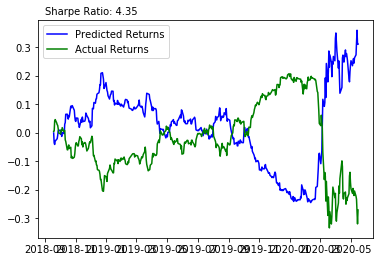

In [26]:
JPM['strategy_cu_return']=0
JPM['market_cu_return']=0
JPM.iloc[-p_data:,JPM.columns.get_loc('strategy_cu_return')]\
= np.nancumsum(JPM['str_ret'][-p_data:])
JPM.iloc[-p_data:,JPM.columns.get_loc('market_cu_return')]\
= np.nancumsum(JPM['Return'][-p_data:])

Sharpe = (JPM['strategy_cu_return'][-1]-JPM['market_cu_return'][-1])\
/np.nanstd(JPM['strategy_cu_return'][-p_data:])

plt.plot(JPM['strategy_cu_return'][-p_data:],color = 'b',label = 'Predicted Returns')
plt.plot(JPM['market_cu_return'][-p_data:],color = 'g',label = 'Actual Returns')
plt.figtext(0.14,0.9,s='Sharpe Ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()

# Conclusion

This was a great example to implement Regression Testing for verification. This was also a great example to learn and implement Naive Bayes algorithm to understand the possible share value of JPM